---
# Task 2 - Clustering Analysis

## Imports and Settings

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Imports
import os
import sys
import time
import warnings
from collections import defaultdict
from ipywidgets import widgets, Layout
from IPython.display import display
from IPython.display import Markdown as md

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples


In [3]:
# Matplotlib Settings
plt.style.use(["seaborn-ticks"])
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = "x-large"
sns.set(rc=dict(plt.rcParams))


## Visualisation

### Full Data Visualisation

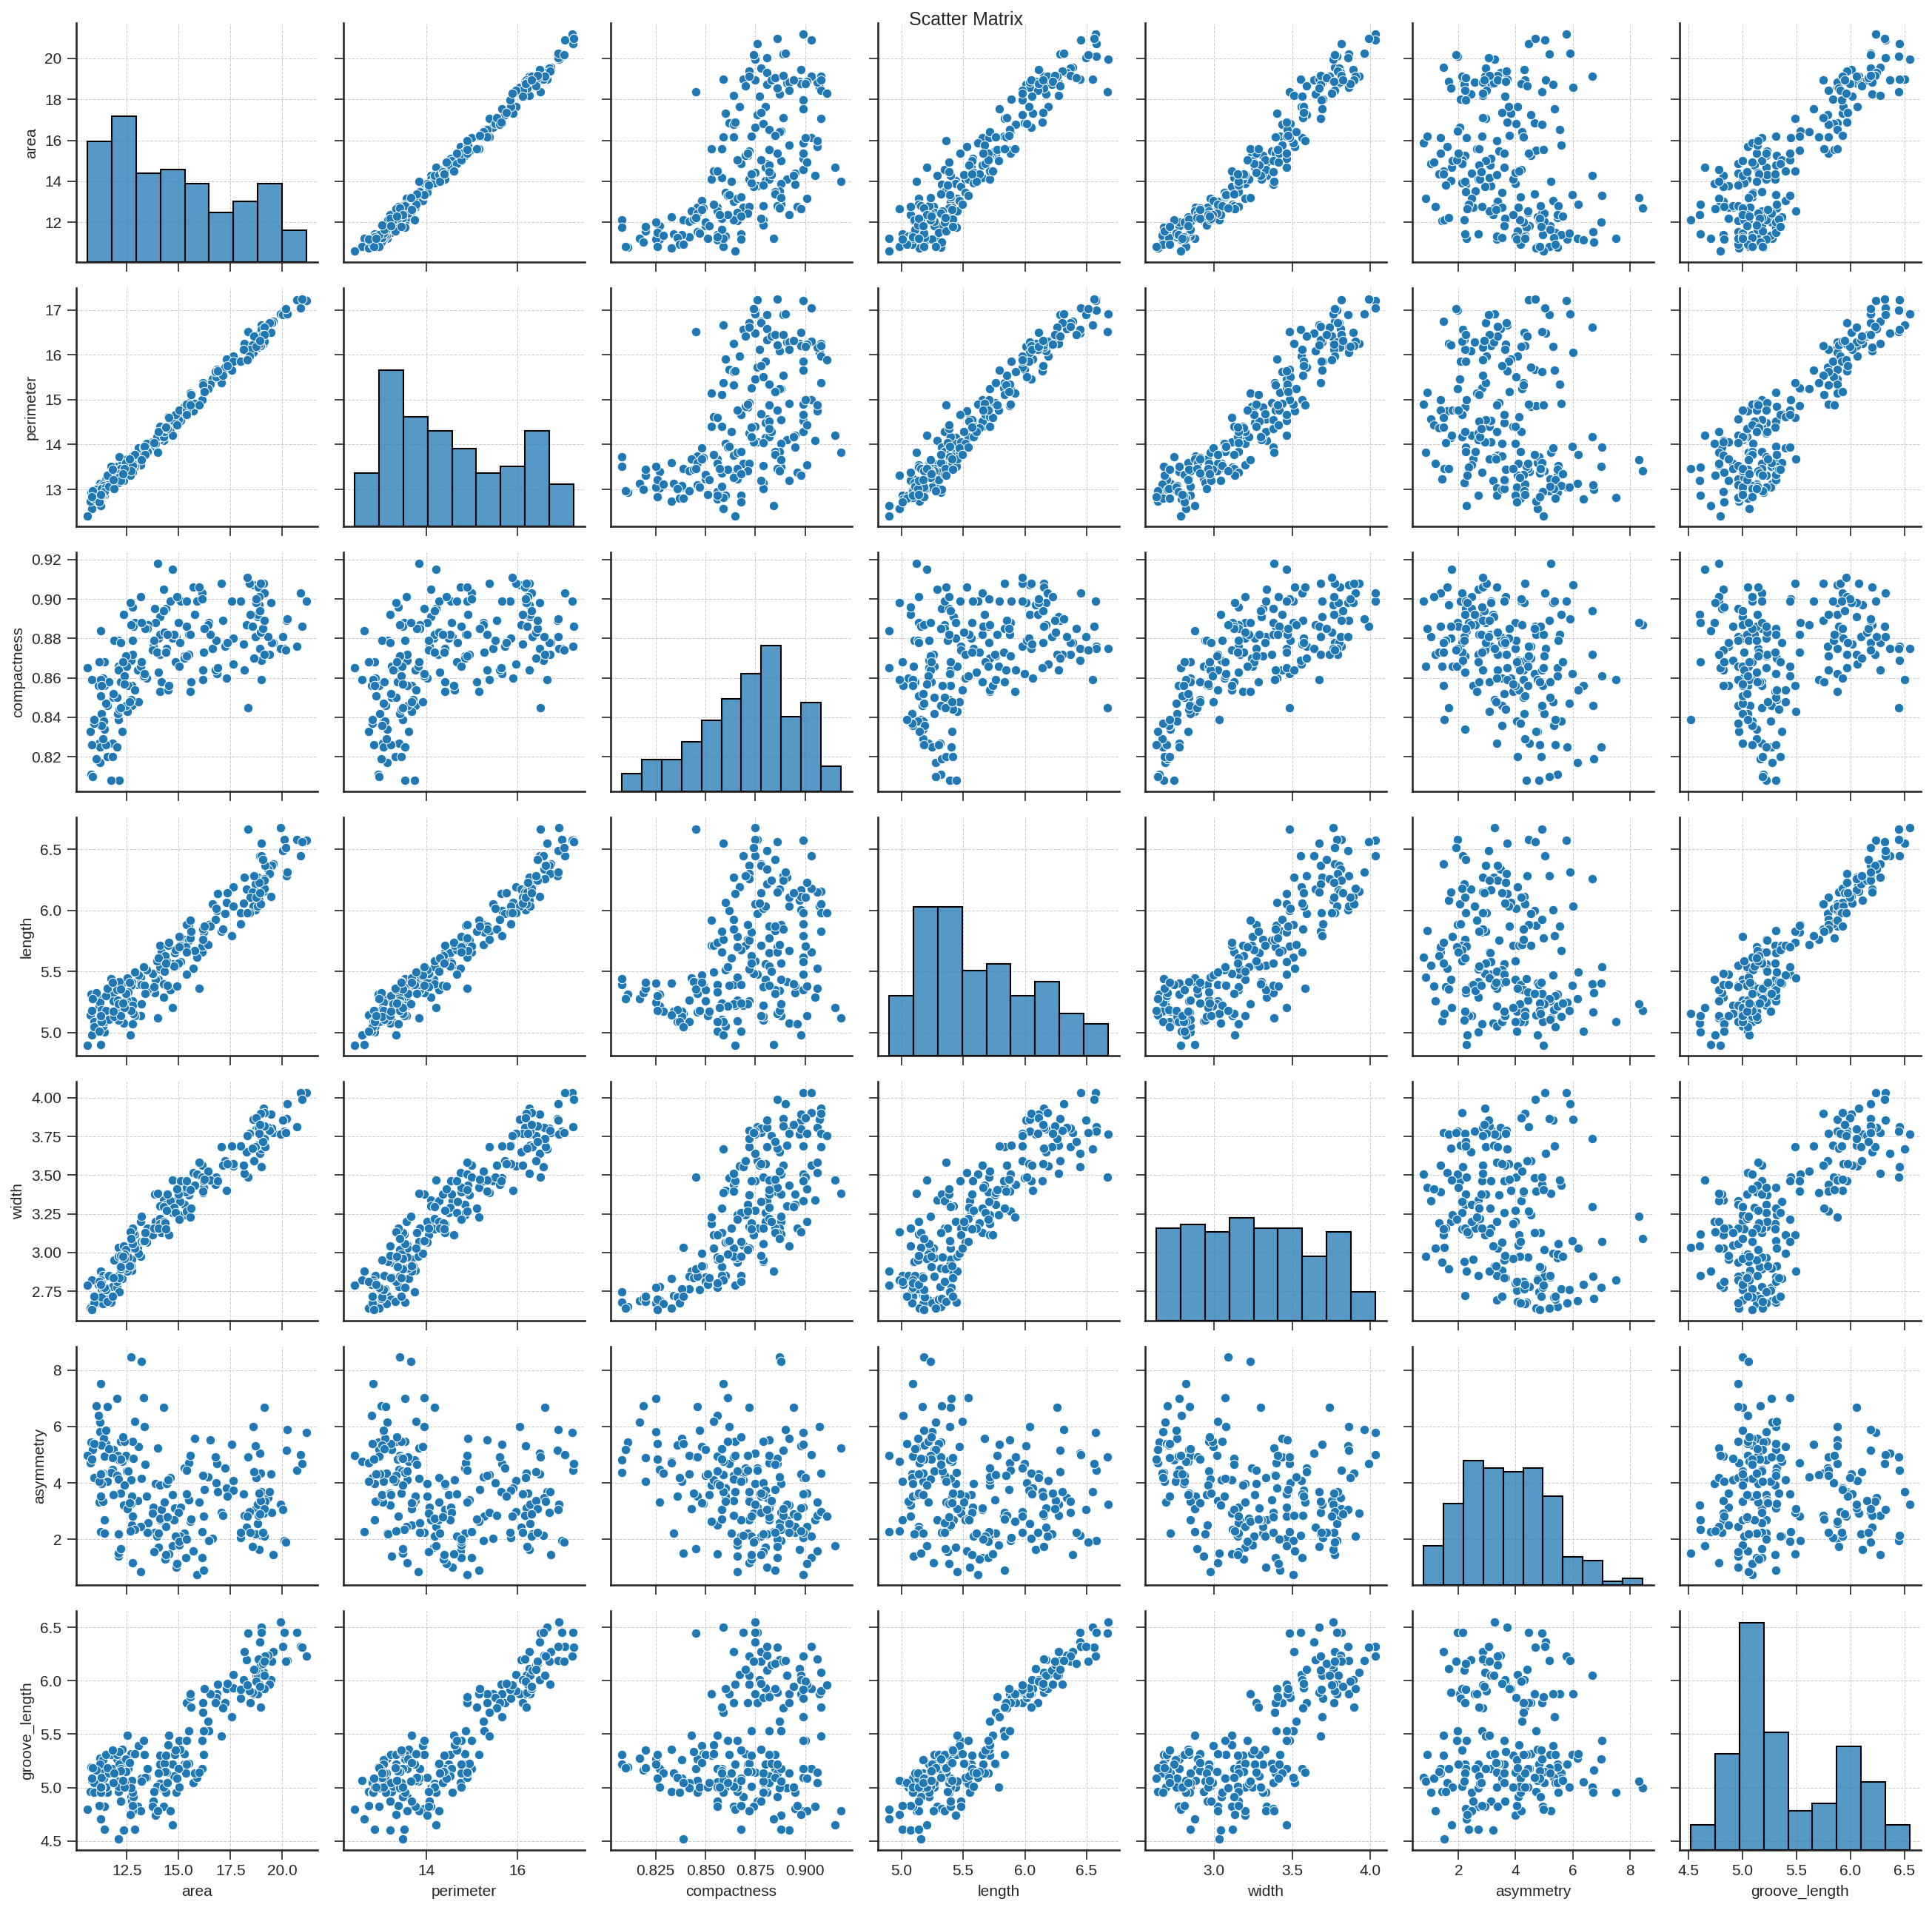

In [4]:
seeds_df = pd.read_csv("./data/seeds.csv")
sns.pairplot(seeds_df)
plt.suptitle("Scatter Matrix");

To get an understanding of the distribution of the seeds dataset, we visualise a scatter_matrix using seaborn

We perform some initial analysis this plot - 
1. Most features are distributed evenly, making it difficult to assign data points to groups.
2. `width` has a very even distribution and would not help in differentiating between groups.
3. The subplots in the bottom row of the figure show clear cluster groupings. Thus it can be said that `groove_length` is an important feature for clustering.
4. The `asymmetry` feature is also helpful for clustering although not as good as `groove_length` 

### PCA reduced data analysis

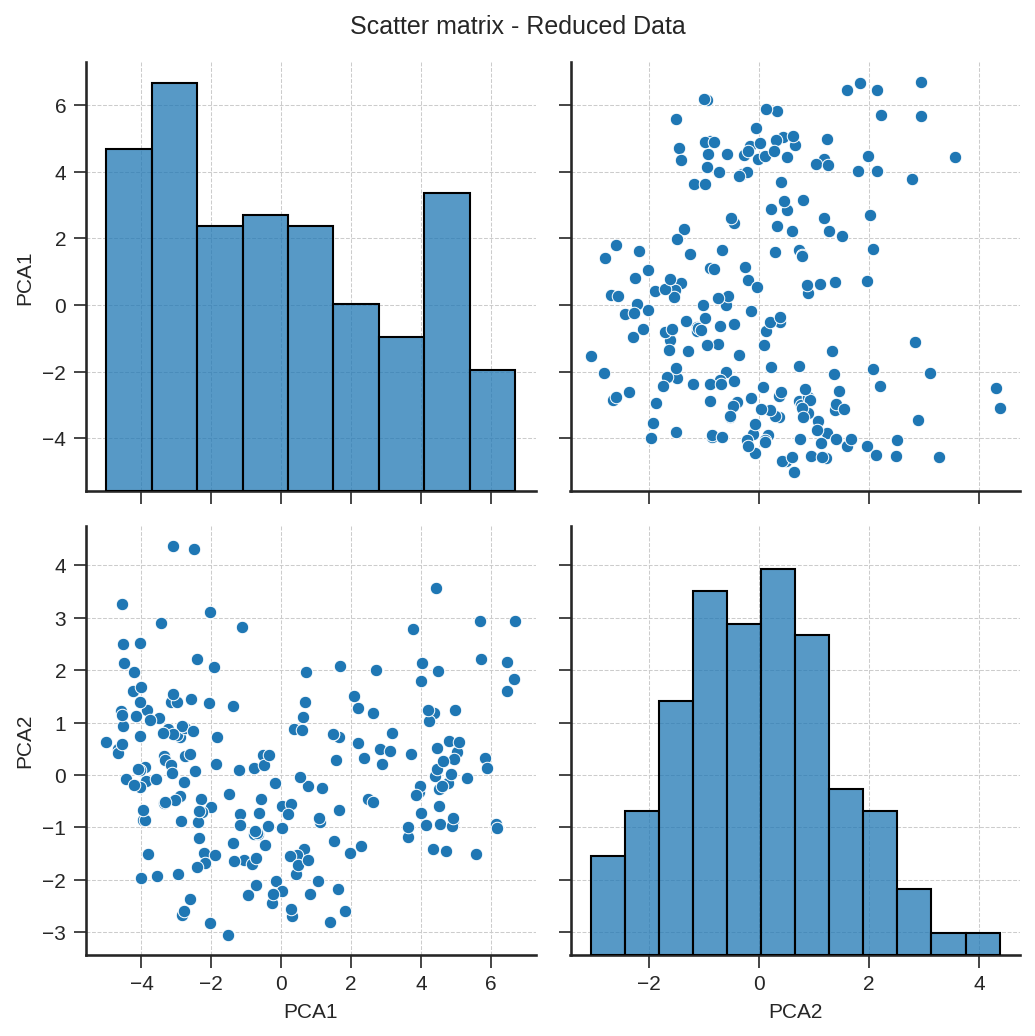

In [5]:
# Apply PCA on data
seeds_pca = PCA(n_components=2, random_state=420)
seeds_pca_df = pd.DataFrame(
    data=seeds_pca.fit_transform(seeds_df), columns=["PCA1", "PCA2"]
)

# Scatter matrix of seeds data
sns.pairplot(seeds_pca_df, height=3.5)
plt.suptitle("Scatter matrix - Reduced Data")
plt.show()


To get an understanding of how the data looks in a 2D space, we perform PCA on the dataset. This will be used to visualise clusters in 2D as well by changing the transforming the cluster centers we get from clustering algorithms.

From the above graph, we can say -
1. There are approximately 3-4 clusters in 2D
1. `DBScan` would be a bad algorithm to apply here as the density of data points in 2D does not vary very much.

Hence we will use **KMeans** and **Gaussian Mixtures** to do our clutering analysis. Although in 2 dimensions, we see a 3-4 clusters on the graph, we will still test models with a varying number of clusters from 2 clusters to 10 to be exact. This is because the 2 dimensional representation of the data using PCA is just an approximation and there might be higher dimensional relationships or groupings that we can potentially miss.

---
## KMeans

KMeans works well with uniformly distributed data. Hence KMeans is a good starting point for clustering this data.


### Workflow
1. Fit n models
3. Do silhouette analysis to get smaller subset of clusters
3. Elbow method using inertia and Average Silhouette score on smaller subset
2. For each model plot using plotting utils to further reduce the set of clusters
4. Take the best model.

### Fit models

#### Implementation Details
1. We use sklearn library to fit KMeans model onto the data.
1. Maintain a dictionary for storing metrics and properties of different models.
1. Maintain a copy of the `seeds_pca_df` for storing predictions for visualisations.
1. Set the random_state of each model to 420 for reproducability

In [6]:
# Set number of clusters
n_clusters = list(range(2, 11))

# Create metrics dict
kmeans_metrics_df = defaultdict(list)
kmeans_metrics_df["n_clusters"] = n_clusters

# Copy PCA dataframe for storing cluster labels
kmeans_labels_df = seeds_pca_df.copy(deep=True)

# Fit and evaluate models
for k in n_clusters:
    # Fit the model
    kmeans = cluster.KMeans(n_clusters=k, random_state=420)
    kmeans.fit(seeds_df)

    # Add labels to kmeans_labels_df
    kmeans_labels_df[f"{k}_clusters_labels"] = kmeans.labels_

    # Append the metrics to the dictionary
    kmeans_metrics_df["Inertia"].append(kmeans.inertia_)
    kmeans_metrics_df["Silhouette Average"].append(
        silhouette_score(seeds_df, kmeans.labels_)
    )
    kmeans_metrics_df["Silhouette Samples"].append(
        silhouette_samples(seeds_df, kmeans.labels_)
    )
    kmeans_metrics_df["Cluster Centers"].append(kmeans.cluster_centers_)

# Convert metrics dict to dataframe
kmeans_metrics_df = pd.DataFrame(kmeans_metrics_df)


### Visualising Clusters

#### Implementation Details

1. Details can be found in the `plot_kmeans` function docstring

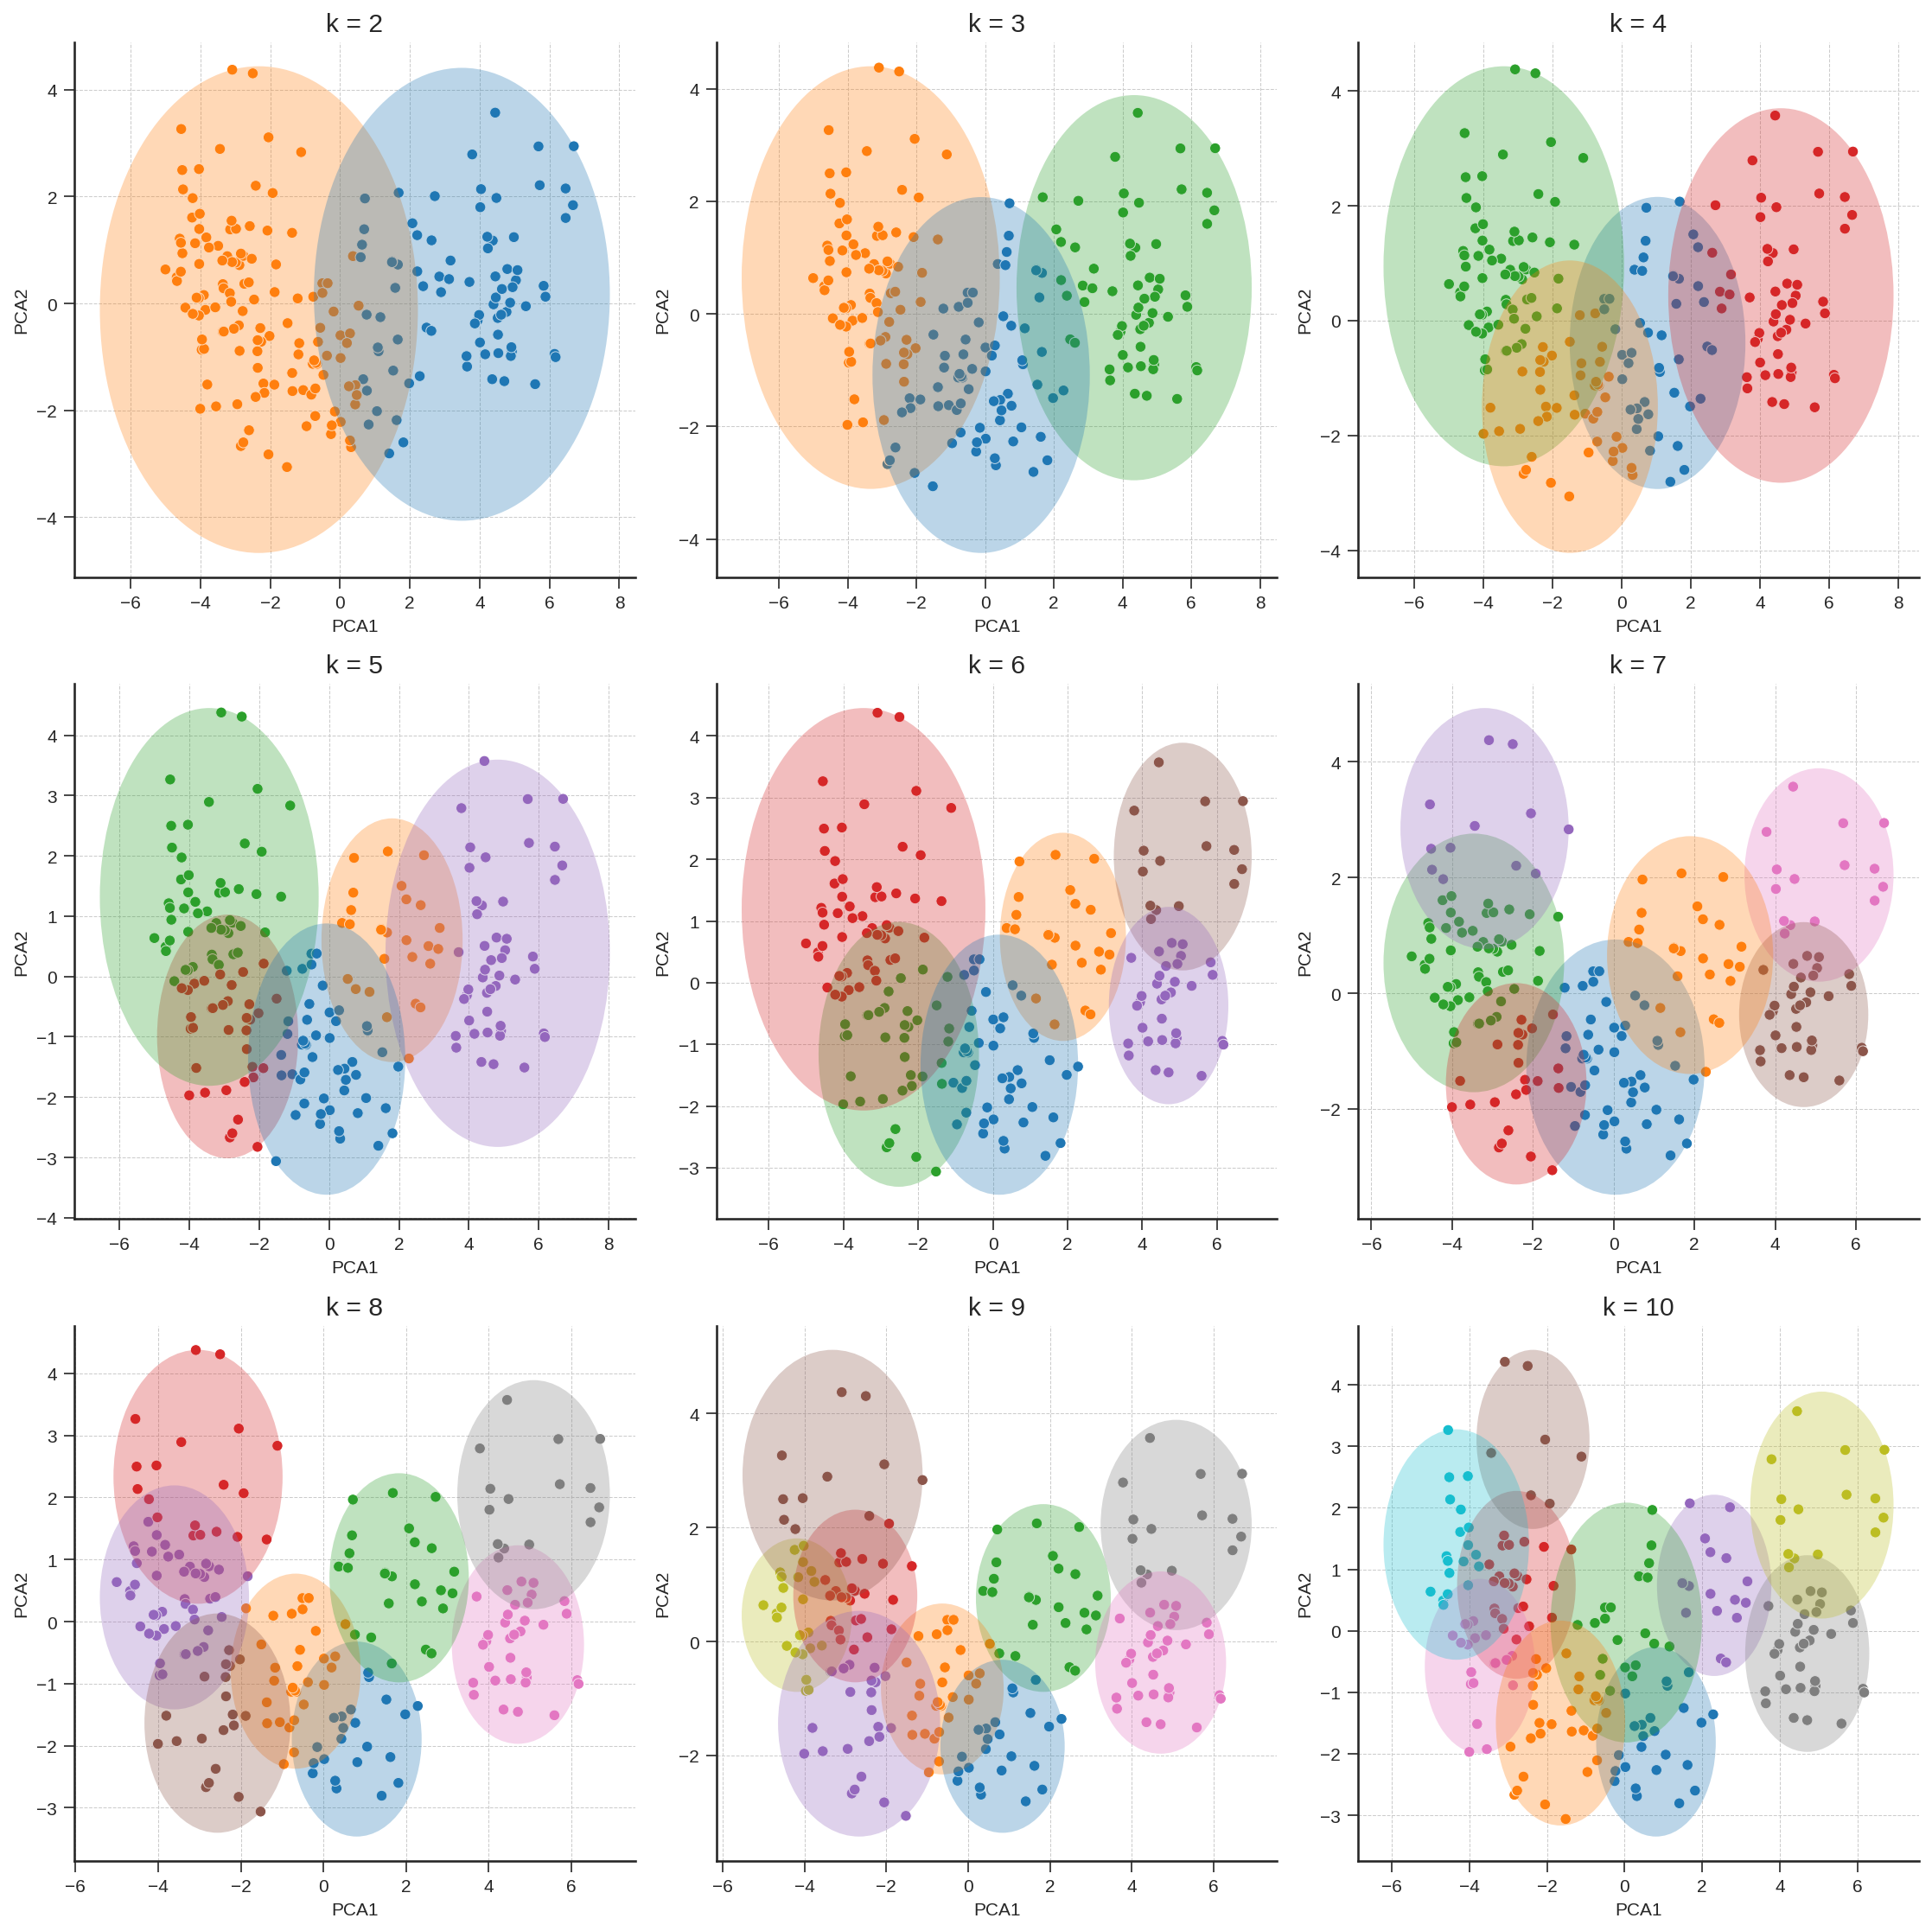

In [7]:
def plot_kmeans(
    kmeans_labels_df: pd.DataFrame,
    kmeans_metrics_df: pd.DataFrame,
    pca_model: PCA,
    k: int,
    ax=None,
):
    """
    Function to plot visualise KMeans clusters using circles.

    Args:
        kmeans_labels_df (pd.DataFrame): DataFrame containing kmeans labels and PCA datapoints for each model
        kmeans_metrics_df (pd.DataFrame): DataFrame containing properties of each model.
        pca_model (PCA): PCA model already fitted on the data
        k (int): Number of clusters to draw
        ax (_type_, optional): Axis on which to draw the figure. Defaults to None.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

    # Get centers
    centers = kmeans_metrics_df.loc[kmeans_metrics_df["n_clusters"] == k, "Cluster Centers"].values[0]
    centers = pca_model.transform(centers)   # Transform the cluster centers using previously fitted PCA model

    # Get radius
    radii = [
        cdist(
            kmeans_labels_df.loc[
                kmeans_labels_df[f"{k}_clusters_labels"] == i, ["PCA1", "PCA2"]
            ],
            [center],
        ).max()
        for i, center in enumerate(centers)
    ]

    # Get color palette
    unique = kmeans_labels_df[f"{k}_clusters_labels"].unique()
    palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Plot clusters
    sns.scatterplot(
        kmeans_labels_df,
        x="PCA1",
        y="PCA2",
        hue=f"{k}_clusters_labels",
        ax=ax,
        palette=palette,
    )
    for c, r, col in zip(centers, radii, palette):
        ax.add_patch(plt.Circle(c, r, fc=col, lw=3, zorder=1, alpha=0.3))
    ax.set_title(f"k = {k}")
    ax.get_legend().remove()


# Create subplot figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plot the clusters
for i, ax in enumerate(axes):
    plot_kmeans(kmeans_labels_df, kmeans_metrics_df, seeds_pca, i + 2, ax=ax)


### Silhouette Analysis
Given $a$ mean intracluster distance and $b$ mean nearest cluster distance, then the Silhouette of a sample is defined as -
$$
C_S = \frac{b-a}{\max{(a,b)}}
$$
- Ranges from $[-1, 1]$
    - $+1 \implies$ instance is well inside its own cluster and far from neighbourhoods
    - $-1 \implies$ assigned to wrong cluster
    - $0 \implies$ cluster boundary
- The Silhouette score is the mean of the silhouette of every sample in the dataset.

#### Implementation Details

This code has been inspired from lecture notes as well as [sklearn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). 

Text(0.5, 0.98, 'Silhouette Analysis')

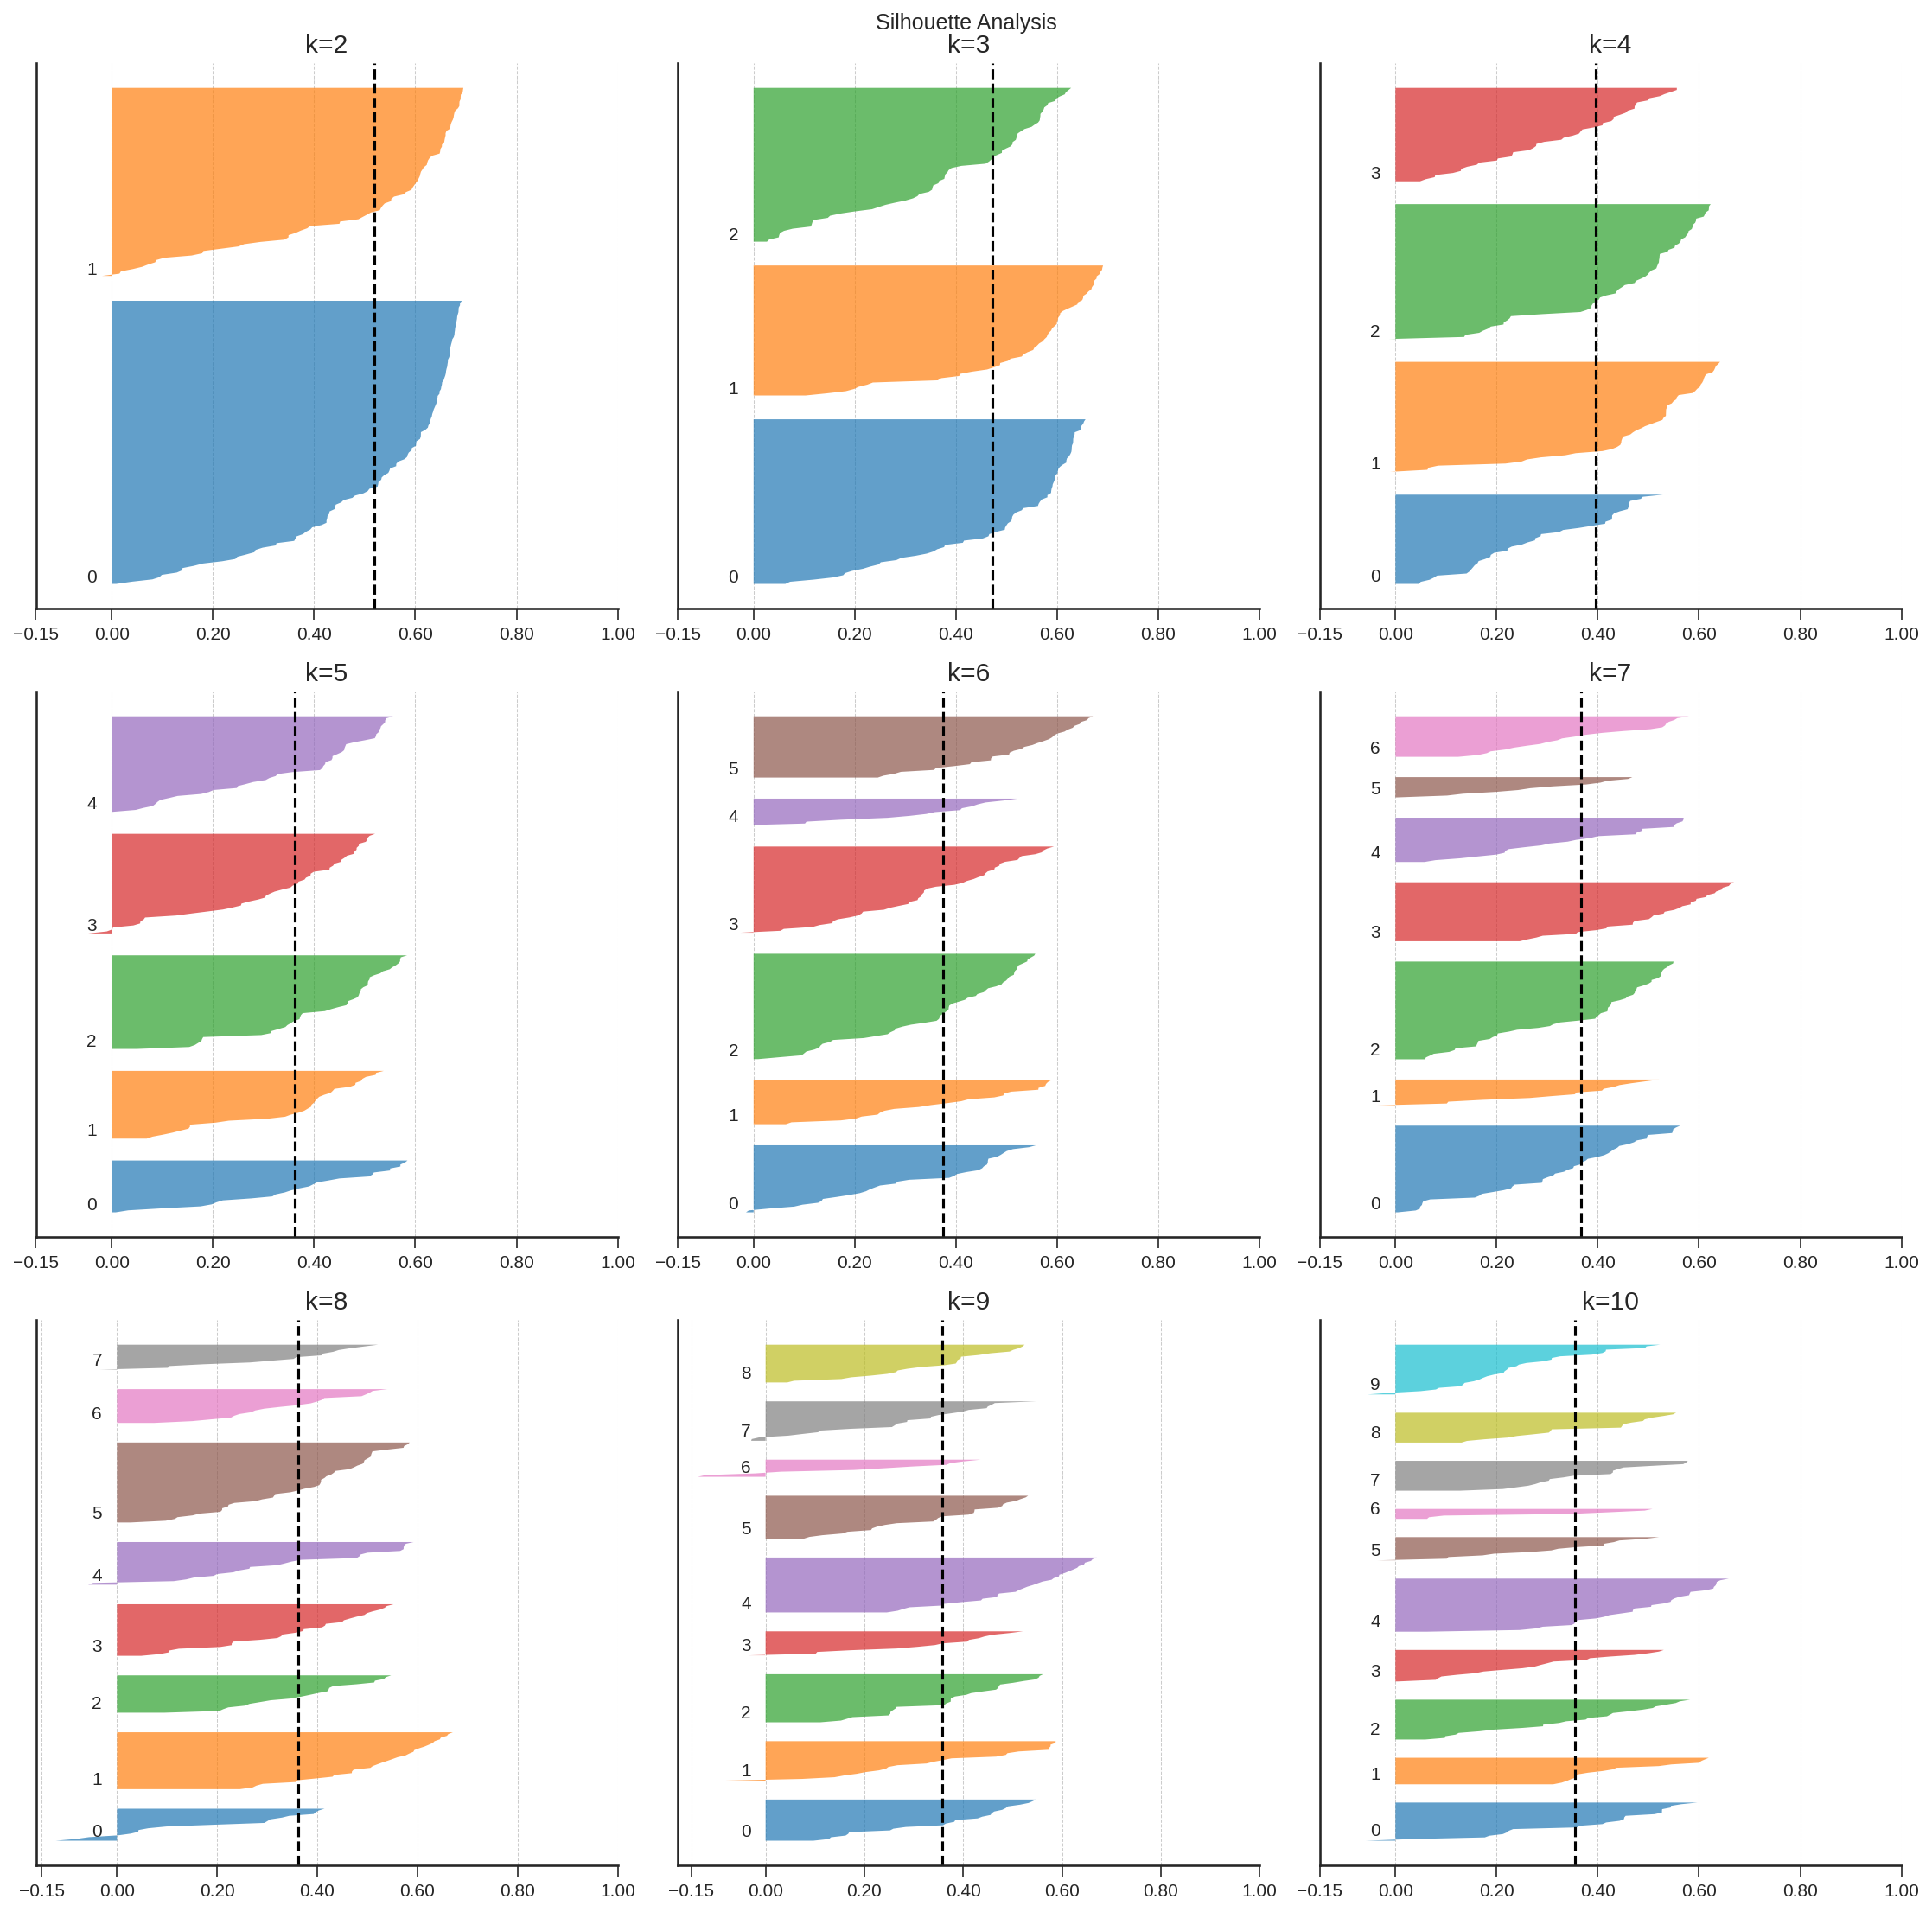

In [8]:
# Create plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Loop over all n_clusters
for k in n_clusters:
    # Get silhouette values
    sil_score = kmeans_metrics_df.loc[
        kmeans_metrics_df["n_clusters"] == k, "Silhouette Average"
    ].values[0]
    sil_values = kmeans_metrics_df.loc[
        kmeans_metrics_df["n_clusters"] == k, "Silhouette Samples"
    ].values[0]
    labels = kmeans_labels_df[f"{k}_clusters_labels"].values

    # Set lower limit for better visulaisation
    y_lower = 10

    # Loop over all clusters
    for i in range(k):
        # Get samples belonging to cluster i
        ith_cluster_sil_values = sil_values[labels == i]
        ith_cluster_sil_values.sort()

        # Get y_upper
        num_samples = ith_cluster_sil_values.shape[0]
        y_upper = num_samples + y_lower

        # Create the plot
        axes[k - 2].fill_betweenx(
            np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, alpha=0.7
        )
        # Label the silhouette plots with their cluster numbers at the middle
        axes[k - 2].text(-0.05, y_lower + 0.3 * k, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axes[k - 2].set_title(f"k={k}")
    axes[k - 2].axvline(x=sil_score, color="black", linestyle="--")

    axes[k - 2].set_yticks([])  # Clear the yaxis labels / ticks
    axes[k - 2].set_xticks([-0.15, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle("Silhouette Analysis")


#### Analysis
From the above graph, we can see that when

- **n_clusters = [2, 3. 4]**
    - The sizes of each cluster is big and somewhat even
    - All the clusters easily cross the average silhouette score  

<break>

- **n_clusters = 5**
    - The cluster sizes are not exactly even but most of them roughly the same size 
    - All the clusters easily cross the average silhouette score
    - *Cluster 3* have some negative silhouette scores but not enough to discard the model


<break>

- **n_clusters = 6**
    - The cluster sizes are uneven but not enough to discard the model 
    - All the clusters easily cross the average silhouette score
    - *Clusters [0, 4]* have some negative silhouette scores but not enough to discard the model

<break>

- **n_clusters = 7**
    - Cluster sizes are uneven enough to discard the model
    - *Cluster 1* has some negative silhouette scores but not enough to discard the model

<break>

- **n_clusters = 8**
    - Cluster sizes are completely uneven
    - *Cluster 0* barely crosses the average silhouette score
    - *Clusters [0, 4]* also have negative silhouette scores for some samples

<break>

- **n_clusters = 9**
    - Cluster sizes are somewhat even but very small indicating that there are too many clusters
    - *Cluster 6* barely crosses the average silhouette score
    - *Cluster [1, 3, 6, 7]* also have negative silhouette scores for some samples

<break>

- **n_clusters = 10**
    - Cluster sizes are somewhat even but very small indicating that there are too many clusters
    - *Clusters [0, 5, 9]* have negative silhouette scores for some samples

<break>

Hence we will remove the models with n_clusters in [8, 9, 10] and proceed with the elbow method using Inertia score for choosing the best model

### Filter the Models set and plot the inertia scores

#### Implementation Details

1. First we filter the dataframe containing and consider only models with `n_clusters <= 7`.
1. Then we create a new metric - `Silhouette Average*1000`. This is just the Silhouette Average Score multiplied by 1000. This is just so that we can plot `Inertia` and `Silhouette Average * 1000` on the same figure

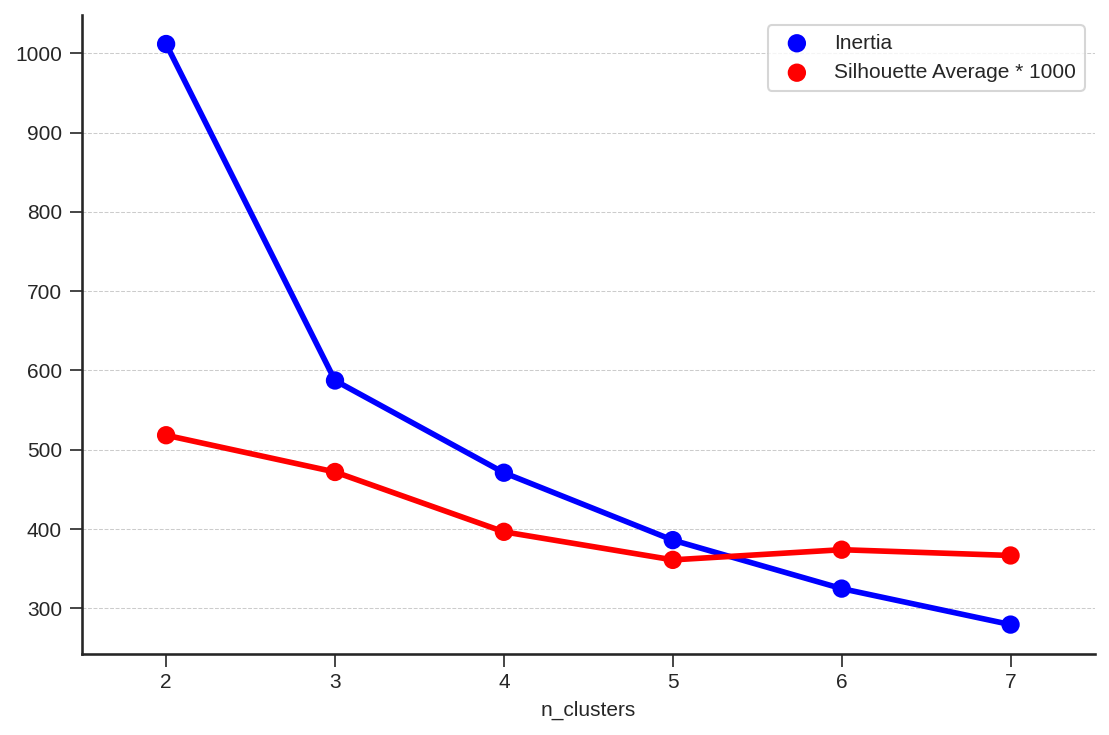

In [9]:
# Filter the dataset and Create a metric - Average Silhouette * 1000 for comparision on the same graph
kmeans_metrics_df = kmeans_metrics_df.loc[kmeans_metrics_df["n_clusters"] <= 7, :]
kmeans_metrics_df["Silhouette Average*1000"] = (
    kmeans_metrics_df["Silhouette Average"] * 1000
)

# Plot the metrics
sns.pointplot(
    kmeans_metrics_df, x="n_clusters", y="Inertia", color="blue", label="Inertia"
)
sns.pointplot(
    kmeans_metrics_df,
    x="n_clusters",
    y="Silhouette Average*1000",
    color="red",
    label="Silhouette Average * 1000",
)
plt.ylabel("")
plt.legend();


### Result

From this graph we see that the optimal tradeoff is achieved when `n_clusters = 3`. 

Hence we conclude that **n_clusters = 3** is optimal number of clusters for this dataset when we do `KMeans` clustering.

---
## Gaussian Mixture Models

While KMeans works well, it does not give probability of a sample belonging to a cluster. Gaussian Mixture Models on the other hand give the probabilities for each cluster. This gives a confidence score for the predictions made and can help improve the model


### Workflow
1. Fit n models
2. Visulaize the models by drawing ellipsoids.
3. Calculate AIC and BIC scores of each model.
4. Take the best model using AIC and BIC.

### Fit models

#### Implementation Details
1. Implementation is similar to the KMeans code above
1. We use sklearn library to fit GaussianMixture model onto the data.
1. Maintain a dictionary for storing metrics and properties of different models.
1. Maintain a copy of the `seeds_pca_df` for storing predictions for visualisations.
1. Set the random_state of each model to 420 for reproducability

In [10]:
# Set number of clusters
n_clusters = list(range(2, 11))

# Create metrics dict
gmm_metrics_df = defaultdict(list)
gmm_metrics_df["n_clusters"] = n_clusters

# Copy PCA dataframe for storing cluster labels
gmm_labels_df = seeds_pca_df.copy(deep=True)

# Fit and evaluate models
for k in n_clusters:
    # Fit the model
    gmm = GaussianMixture(n_components=k, random_state=420)
    gmm.fit(seeds_df)

    # Add labels to gmm_labels_df
    gmm_labels_df[f"{k}_clusters_labels"] = gmm.predict(seeds_df)

    # Append the metrics to the dictionary
    gmm_metrics_df["Weights"].append(gmm.weights_)
    gmm_metrics_df["Means"].append(gmm.means_)
    gmm_metrics_df["Covariances"].append(gmm.covariances_)
    gmm_metrics_df["AIC"].append(gmm.aic(seeds_df))
    gmm_metrics_df["BIC"].append(gmm.bic(seeds_df))

# Convert metrics dict to dataframe
gmm_metrics_df = pd.DataFrame(gmm_metrics_df)


### Visualising Models
#### Implementation Details

Details can be found in the `plot_kmeans` function docstring

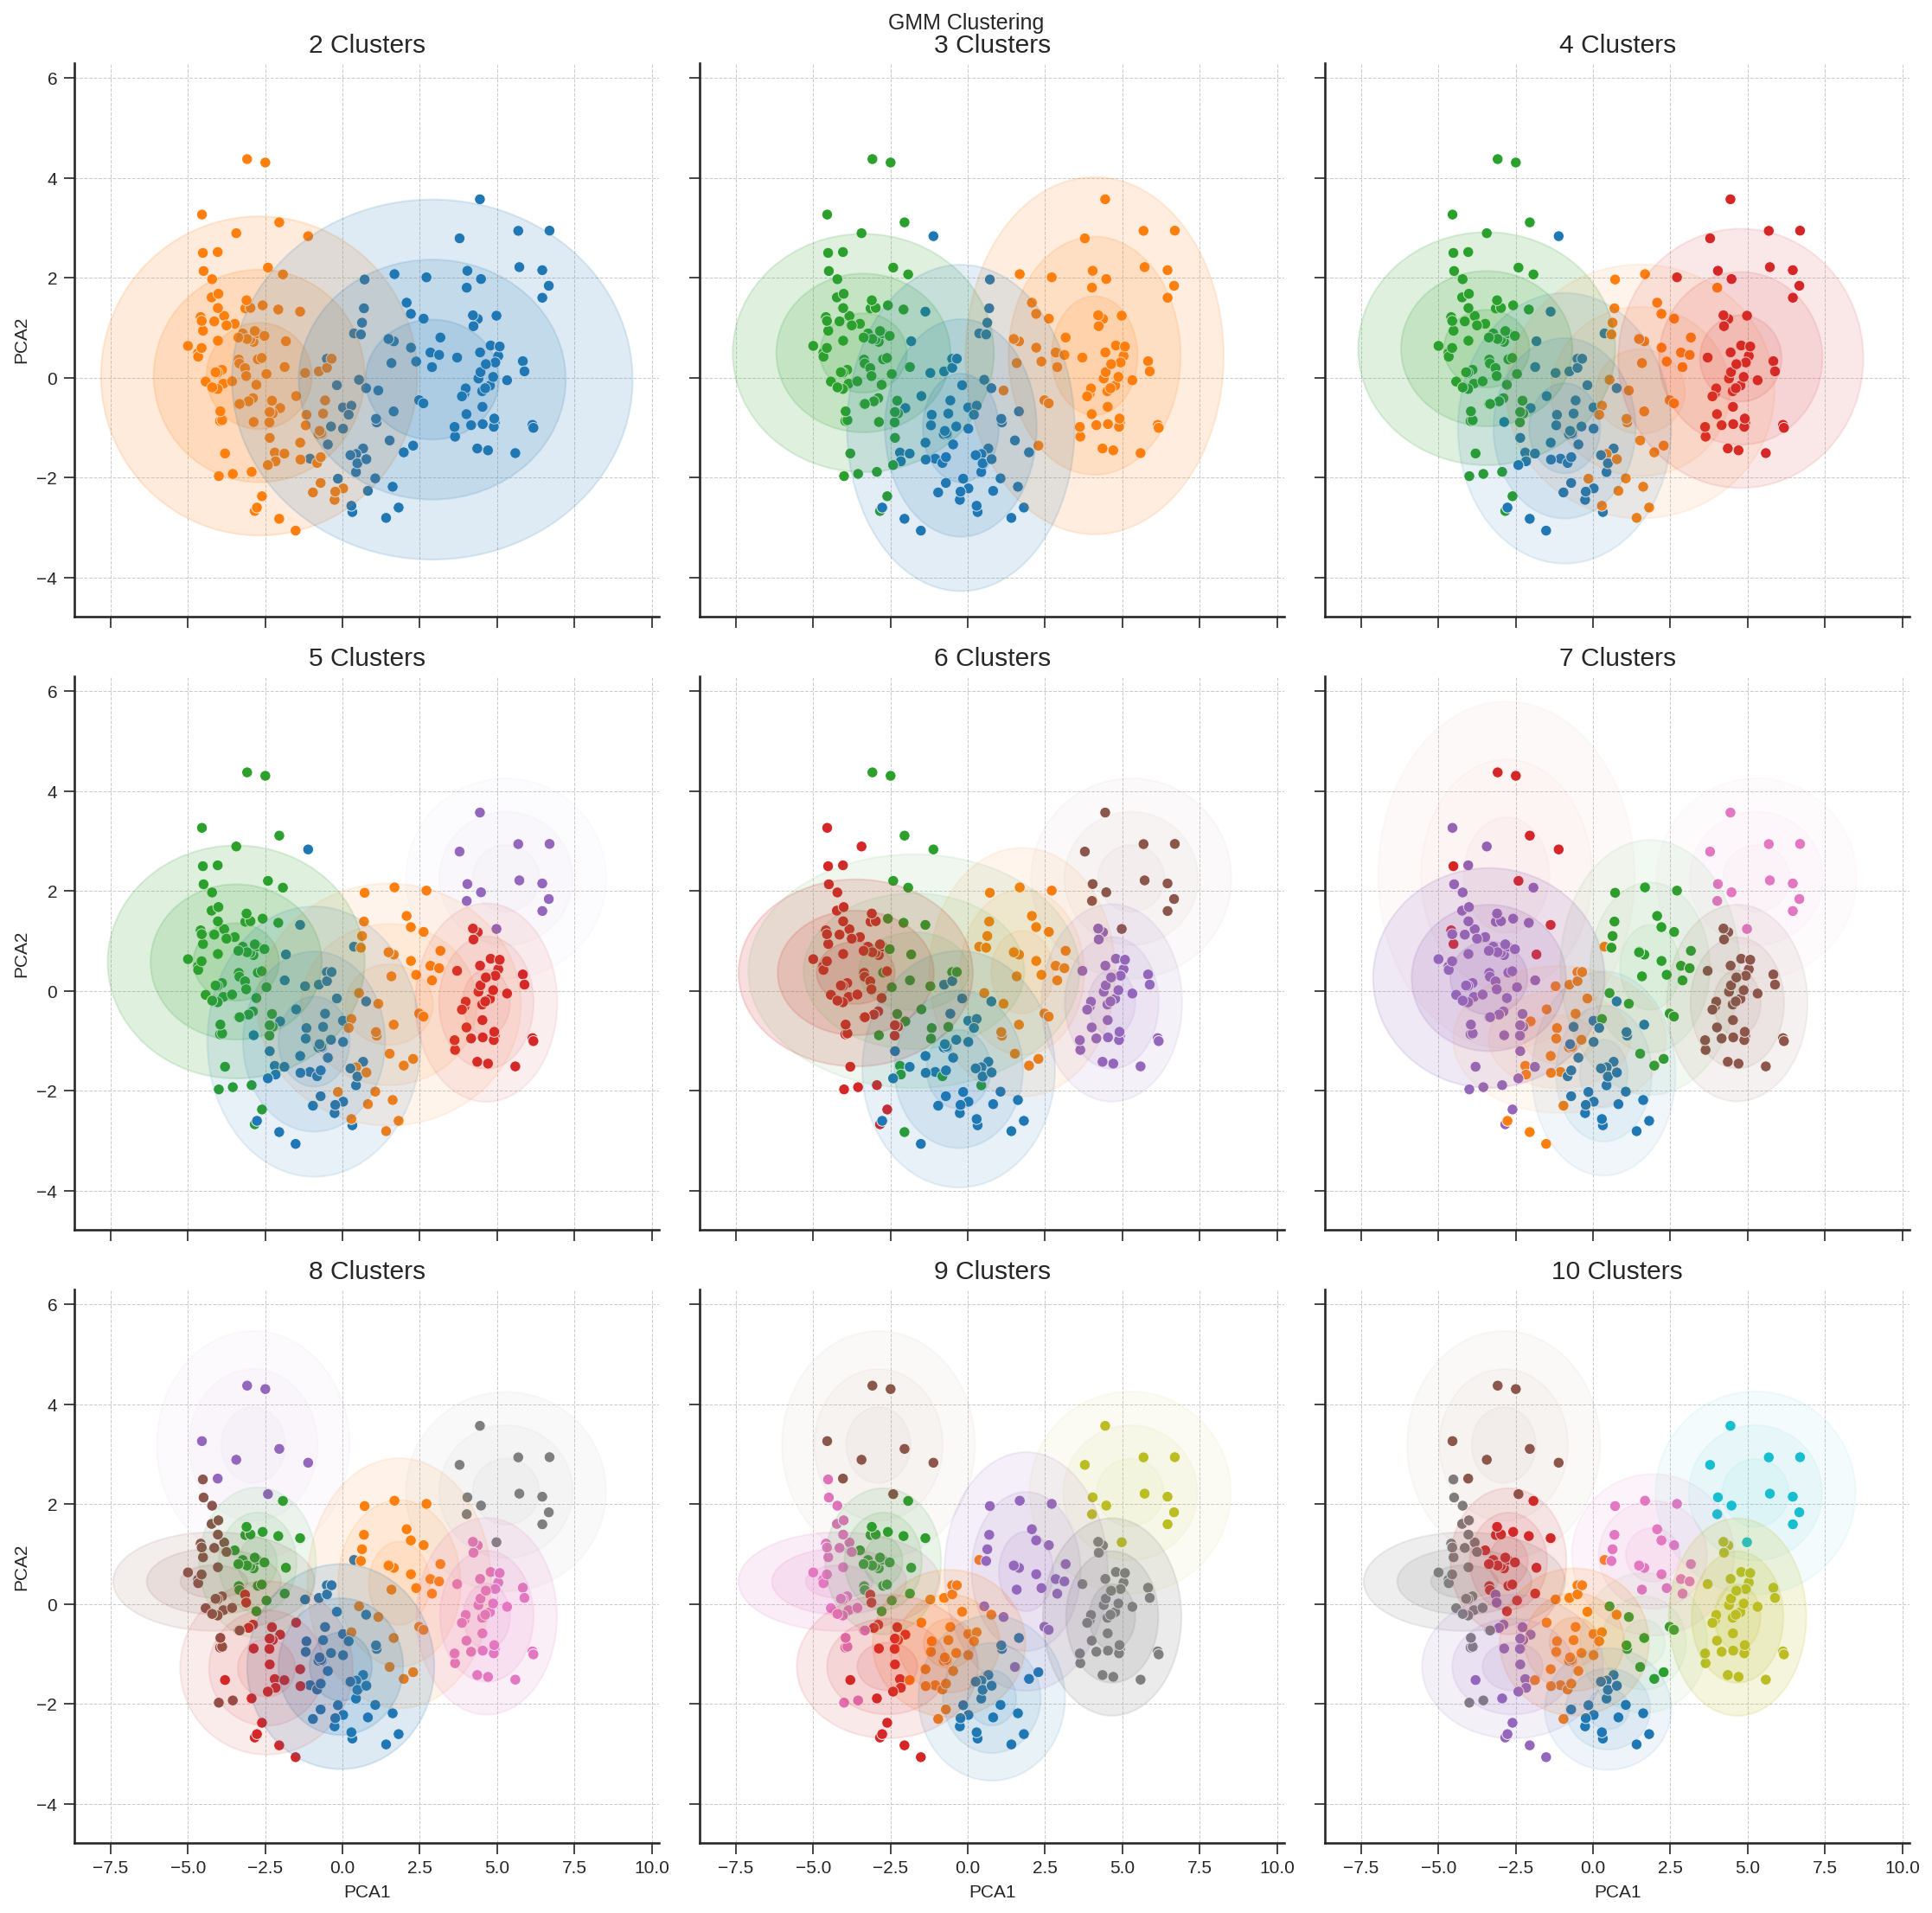

In [11]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance

    Inspired By: VanderPlas, Jake (2016). Python Data Science Handbook. O'Reilly Media, Inc. ISBN: 9781491912058
    """
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        U, s, Vt = np.linalg.svd(covariance)
        width, height = 2 * np.sqrt(s[:2])

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position[0], nsig * width, nsig * height, angle, **kwargs))


def plot_gmm(
    gmm_metrics_df: pd.DataFrame,
    gmm_labels_df: pd.DataFrame,
    pca_model: PCA,
    k: int,
    ax=None,
):
    """Plot the GMM clusters with varying levels of certainty.
    
    Inspired By: VanderPlas, Jake (2016). Python Data Science Handbook. O'Reilly Media, Inc. ISBN: 9781491912058
    
    Args:
        gmm_labels_df (pd.DataFrame): DataFrame containing gmm labels and PCA datapoints for each model
        gmm_metrics_df (pd.DataFrame): DataFrame containing properties of each model.
        pca_model (PCA): PCA model already fitted on the data
        k (int): Number of clusters to draw
        ax (_type_, optional): Axis on which to draw the figure. Defaults to None.
        reverse (bool, optional): Reverse the palette colors. Defaults to False.
    """

    # Get palette
    unique = gmm_labels_df[f"{k}_clusters_labels"].unique()
    palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    sns.scatterplot(
        gmm_labels_df,
        x="PCA1",
        y="PCA2",
        hue=f"{k}_clusters_labels",
        palette=palette,
        ax=ax,
    )

    # Get metrics
    weights = gmm_metrics_df.loc[gmm_metrics_df["n_clusters"] == k, "Weights"].values[0]
    means = gmm_metrics_df.loc[gmm_metrics_df["n_clusters"] == k, "Means"].values[0]
    covariances = gmm_metrics_df.loc[gmm_metrics_df["n_clusters"] == k, "Covariances"].values[0]

    # Draw ellipse
    w_factor = 0.15 / weights.max()
    for pos, covar, w, c in zip(means, covariances, weights, palette):
        draw_ellipse(
            position=pca_model.transform(pos.reshape(-1, 7)),   # Transform the cluster centers using previously fitted PCA model
            covariance=covar,
            alpha=w * w_factor,
            ax=ax,
            color=c,
        )

    # Set title
    ax.set_title(f"{k} Clusters")


fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    plot_gmm(gmm_metrics_df, gmm_labels_df, seeds_pca, i + 2, ax=ax)
    ax.get_legend().remove()
plt.suptitle("GMM Clustering");

### Model Selection

**Akaike Information Criterion (AIC)**
- It is a measure of relative fit of several statistical models to data.
- Used to select which model best represents the data, in other words the model that most adequately describes and unkonwn, high dimensional reality.
- AIC presents the danget of overfitting.
- *Lower the score, better the model.*
- Given observed data $x$, num parameters $k$, MLE of the parameters $\hat\theta$ and model likelihood $L$, the AIC is calculated as 
$$
AIC = 2k - 2\log(L(\hat\theta|x))
$$


**Bayesian Information Criterion (BIC)**
- Related AIC, but gives a stronger penalty based on the number of parameters.
- Used to select a True model among the set of candidates.
- BIC presents the danger of underfitting the model by penalising it too much.
- *Lower the score, better the model.*
- Given observed data $x$, num parameters $k$, MLE of the parameters $\hat\theta$ and model likelihood $L$, the AIC is calculated as 
$$
BIC = k\log(n) - 2\log(L(\hat\theta|x))
$$

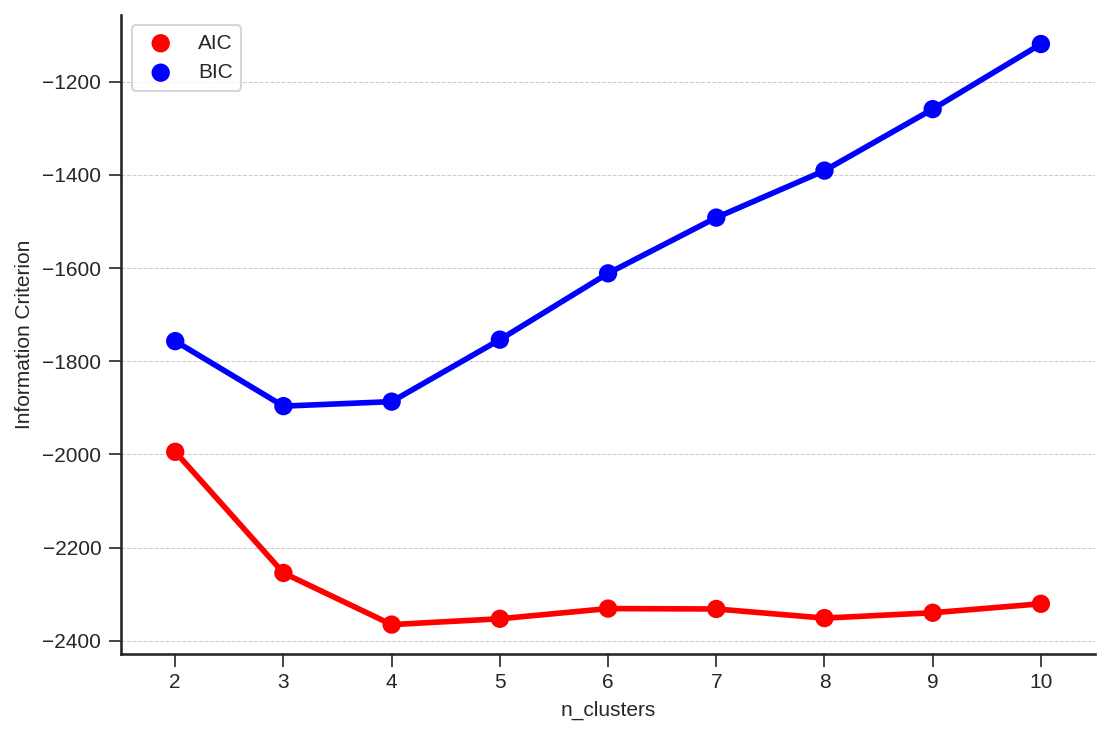

In [12]:
# AIC, BIC
sns.pointplot(gmm_metrics_df, x="n_clusters", y="AIC", color="red", label="AIC")
sns.pointplot(gmm_metrics_df, x="n_clusters", y="BIC", color="blue", label="BIC")
plt.ylabel("Information Criterion")
plt.legend();

### Result

From this graph we see that the optimal model is obtained when `n_components = 4`. 

Hence we conclude that **n_components = 4** is optimal number of components for this dataset when we do `Gaussian Mixture` clustering.

## Compare KMEans and GMM

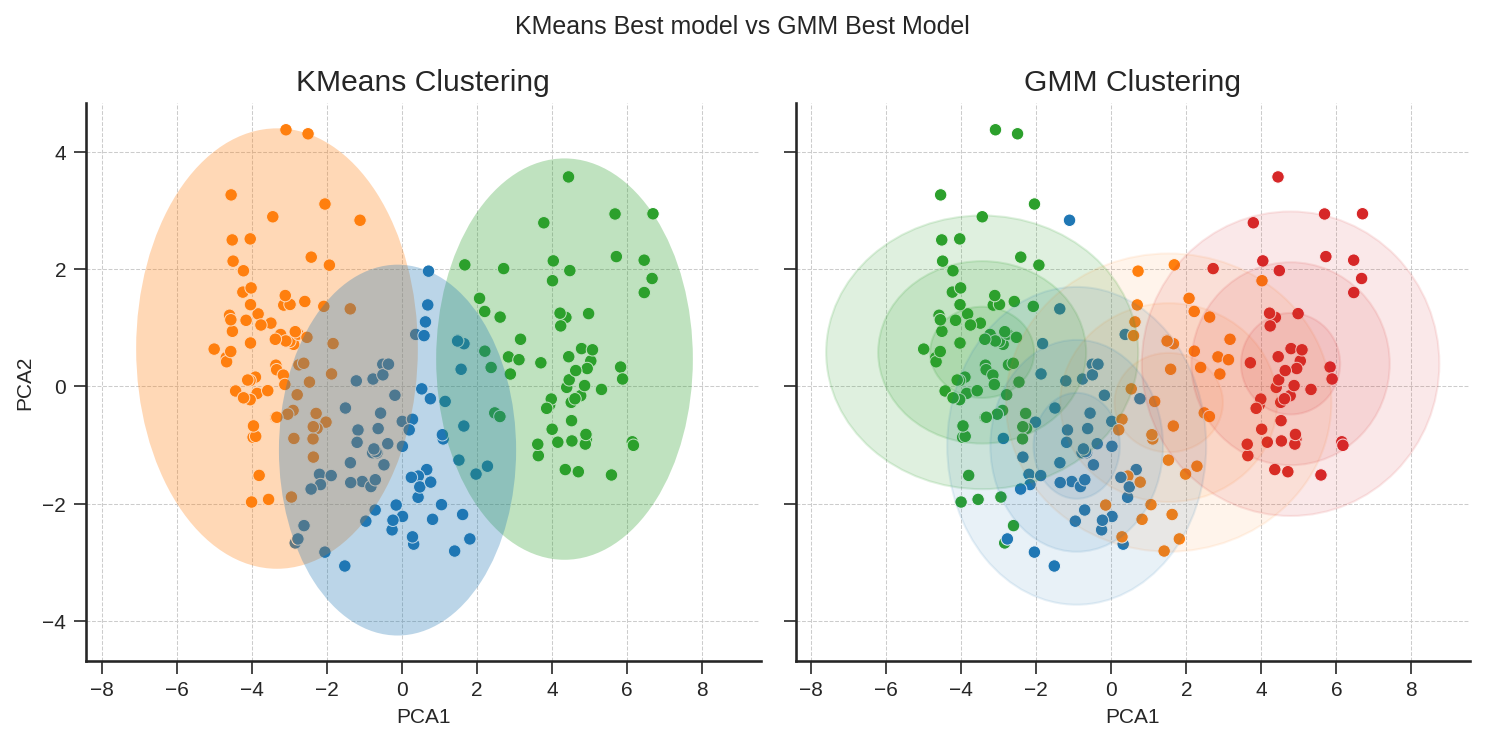

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.flatten()

plot_kmeans(kmeans_labels_df, kmeans_metrics_df, seeds_pca, 3, ax=axes[0])
axes[0].set_title("KMeans Clustering")

plot_gmm(gmm_metrics_df, gmm_labels_df, seeds_pca, 4, ax=axes[1])
axes[1].set_title("GMM Clustering")
axes[1].get_legend().remove()

plt.suptitle(f"KMeans Best model vs GMM Best Model")
plt.show();

### Result

Comparing these 2 we see that both GMM and KMeans have done a similar job of clustering the data samples. 

In [15]:
# If facing with memory issues run this cell!

# WARNING: 
# This will effectively reset the jupyter notebook and erase all variables
# and has been provided to refresh the notebook between different tasks.

%reset -f